# Script to Convert Sea Ice Concentration Data to Geodetic Lat/Lon Coordinates
**Description:** Reads in data from the NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4, converts the coordinates from polar stereographic to geodetic lat/lon, and extracts data for a particular area and variable of interest.  
**Input Data:** NetCDF files of NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4 data.  
**Output Data:** NetCDF file of coordinate-converted data for the variable and spatial extent of interest.  
**Author:** Emma Perkins  
**Date:** July 2022  

### Import Relevant Packages

In [1]:
# this is the package or converting from polar stereographic coordinates provided by the NSIDC
!pip install /glade/scratch/eperkins/coordinate_convert/polarstereo_lonlat_convert_py/

Processing /glade/scratch/eperkins/coordinate_convert/polarstereo_lonlat_convert_py
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for polarstereo-lonlat-convert-py: filename=polarstereo_lonlat_convert_py-1.0.0-py3-none-any.whl size=6274 sha256=cbb4ef8cca2febbf2b30eb4373bcbbba88b4e1086c24ae5495812dbebeb2a82d
  Stored in directory: /glade/scratch/eperkins/pip-ephem-wheel-cache-vhwnyn1m/wheels/27/20/52/2db6fab80c2735aaf2030ad714b62073abafefb318d4d00673
Successfully built polarstereo-lonlat-convert-py
  Attempting uninstall: polarstereo-lonlat-convert-py
    Found existing installation: polarstereo-lonlat-convert-py 1.0.0
    Uninstalling polarstereo-lonlat-convert-py-1.0.0:
      Successfully uninstalled polarstereo-lonlat-convert-py-1.0.0


In [2]:
import xarray as xr
import glob
import numpy as np
import xesmf as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy import spatial
from polar_convert.constants import NORTH
from polar_convert import polar_xy_to_lonlat

### Load Data - Long Step (Skip for now and Load in Saved Time Matched Data Below to Save Time)
1) Find all filenames and add them to a sorted list.  
2) Read in the data from each of those filenames individually.  
3) Concatenate all of the new datafiles along the time axis into one big datafile.

In [3]:
obs_data = xr.open_dataarray('/glade/scratch/eperkins/data/noaa_ice_conc/seaice_conc_daily_nh_1978_2021_v04r00_noland.nc')

In [4]:
path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/daily/aice_d/'
file1 = path+'b.e11.B1850C5CN.f09_g16.005.cice.h1.aice_d_nh.19000101-19991231.nc'
file2 = path+'b.e11.B1850C5CN.f09_g16.005.cice.h1.aice_d_nh.20000101-20991231.nc'
files = [file1, file2]
clim_data = xr.open_mfdataset(files, concat_dim=None)

In [5]:
data_var = 'aice_d'  # change to variable of interest from climate model data
clim_data = clim_data[data_var]

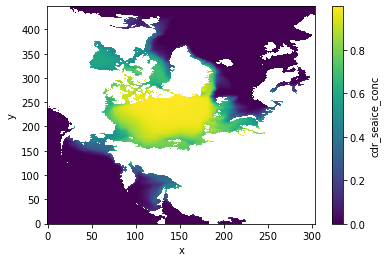

In [6]:
obs_data.mean(dim='tdim').plot()

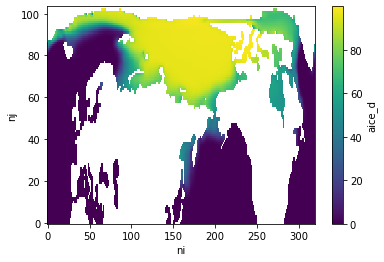

In [7]:
clim_data.mean(dim='time').plot()

### Match Times (Skip for now and Load in Saved Time Matched Data Below to Save Time)
**Description:** Matches temporal extent and resolution of two datasets.  
**Input Data:** Observational data and climate model data with the same temporal resolution (hourly, daily, monthly, etc.) that have already been compressed down to one file using the Script4DataExtraction notebook or python script.  
**Output Data:** Observational data and climate model data with matching time dimensions (same start and end dates as well as same length).  
**Process:**  
1) Matches the start times of the data by determining which dataset has the earlier first date and selecting only the data from that dataset beginning on the first date of the dataset with the later first date.  
2) Matches the end times of the data by determining which dataset has the later last date and selecting only the data from that dataset from the beginning until the last date of the dataset with the earlier last date. *At this point both datasets should have the same start and end date but may still be different lengths if one of them includes leap days while the other does not.*  
3) Address leapday differences checking if the length of the time dimension for both datasets is the same. If it is, the two datasets have been successfully time corrected and are renamed to reflect this new status. Otherwise, the length of the time dimension of the two datasets is not the same so the days that do not appear in the shorter of the two datasets are removed from the longer of the two datasets, presumably these are leap days. After this has been done the datasets are then successfully time-corrected and are renamed to reflect this new status.  
4) Save the time-corrected datasets.

In [8]:
clim_data['time'] = clim_data.indexes['time'].to_datetimeindex()

/glade/work/eperkins/miniconda3/envs/analysis3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


In [9]:
 # 1) match start times-----------------------------------------------------
if np.where(obs_data.time == clim_data.time[0])[0].size > 0:
    obs_start = np.where(obs_data.time == clim_data.time[0])[0][0]
    obs_data = obs_data.isel(time=np.arange(obs_start, len(obs_data.time), 1))
elif np.where(clim_data.time == obs_data.time[0])[0].size > 0:
    clim_start = np.where(clim_data.time == obs_data.time[0])[0][0]
    clim_data = clim_data.isel(time=np.arange(clim_start, len(clim_data.time), 1))

/glade/work/eperkins/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [10]:
# 2) match end times-------------------------------------------------------
if np.where(obs_data.time == clim_data.time[-1])[0].size > 0:
    obs_end = np.where(obs_data.time == clim_data.time[-1])[0][0]
    obs_data = obs_data.isel(time=np.arange(0, obs_end + 1, 1))
elif np.where(clim_data.time == obs_data.time[-1])[0].size > 0:
    clim_end = np.where(clim_data.time == obs_data.time[-1])[0][0]
    clim_data = clim_data.isel(time=np.arange(0, clim_end + 1, 1))

/glade/work/eperkins/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [11]:
%%time

# 3) Address leapday differences--------------------------------------------
obs_data_noleap = np.zeros([len(clim_data.time), len(obs_data.y), len(obs_data.x)])
for i in range(0, len(clim_data.time)):
    index = np.where(obs_data.tdim.time == clim_data.time[i])[0][0]
    obs_data_noleap[i, :, :] = obs_data.isel(tdim=index)

CPU times: user 56min 46s, sys: 39.5 s, total: 57min 25s
Wall time: 57min 44s


In [12]:
x_coord = obs_data.x.to_numpy()
y_coord = obs_data.y.to_numpy()
time_coord = clim_data.time.to_numpy()
obs_data_tc = xr.DataArray(obs_data_noleap, coords={'time': time_coord, 'y': y_coord,
                        'x': x_coord}, dims=['time', 'y', 'x'], name='cdr_seaice_conc') 
clim_data_tc = clim_data

In [14]:
# 4) Save time-corrected datasets
obs_data_tc.to_netcdf('/glade/work/eperkins/obs_sea_ice_tc2.nc')
clim_data_tc.to_netcdf('/glade/work/eperkins/clim_sea_ice_tc2.nc')

### Load Time-Matched Data

In [15]:
obs_data_tc = xr.open_dataarray('/glade/work/eperkins/obs_sea_ice_tc2.nc')
clim_data_tc = xr.open_dataarray('/glade/work/eperkins/clim_sea_ice_tc2.nc')

In [16]:
# convert observational data from fraction to percent to match climate model data
obs_data_tc = obs_data_tc*100

### Regrid Data for Comparison

In [17]:
# select data for just one time step to look at spatial coordinates
clim_data0 = clim_data_tc.isel(time=0)
obs_data0 = obs_data_tc.isel(time=0)

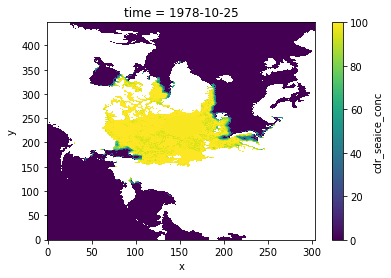

In [18]:
obs_data0.plot()

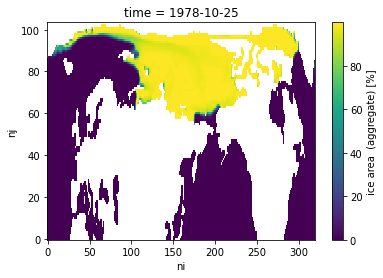

In [19]:
clim_data0.plot()

In [37]:
clim_data0.isel(ni=200).isel(nj=80).TLAT

<xarray.DataArray 'TLAT' ()>
array(81.02167, dtype=float32)
Coordinates:
    time     datetime64[ns] 1978-10-25
    TLON     float32 222.2
    TLAT     float32 81.02
    ULON     float32 ...
    ULAT     float32 ...
Attributes:
    long_name:  T grid center latitude
    units:      degrees_north
    bounds:     latt_bounds

In [39]:
np.where(clim_data0.TLAT == 81.02167)

(array([80, 80]), array([119, 200]))

In [20]:
# create new target grid
target_grid = xe.util.grid_2d(-180, 180, 1, 0, 90, 0.5)

In [21]:
#create map
cesm_regridder = xe.Regridder(clim_data0, target_grid, 'nearest_s2d', periodic=True, reuse_weights=False)

#perform regridding
clim_regrid = cesm_regridder(clim_data0)

/glade/work/eperkins/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


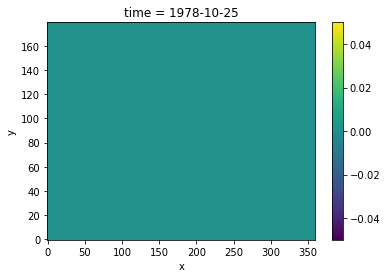

In [22]:
clim_regrid.plot()

In [23]:
# generate array of lat lon coordinates for observational data
x = obs_data0.x
y = obs_data0.y
true_scale_lat = 70  # true-scale latitude in degrees 
re = 6378.137  # earth radius in km
e = 0.01671  # earth eccentricity
hemisphere = NORTH

In [24]:
lon, lat = polar_xy_to_lonlat(x, y, true_scale_lat, re, e, hemisphere)

In [25]:
%%time

obs_space = np.zeros([len(obs_data0.y)*len(obs_data0.x), 4])
idx = 0
for j in range(0, len(obs_data0.y)):
    for i in range(0, len(obs_data0.x)):
        lon_point, lat_point = polar_xy_to_lonlat(x[i], y[j], true_scale_lat, re, e, hemisphere)
        obs_space[idx] = [lat_point, lon_point, i, j]
        idx = idx + 1

CPU times: user 15min 58s, sys: 3.31 s, total: 16min 2s
Wall time: 16min 2s


In [26]:
%%time

clim_space = np.zeros([len(clim_data0.nj)*len(clim_data0.ni), 4])
idx = 0
for j in range(0, len(clim_data0.nj)):
    for i in range(0, len(clim_data0.ni)):
        latlon_point = [float(clim_data0.lat[j, i]), float(clim_data0.lon[j, i]), i, j]
        clim_space[idx] = latlon_point
        idx = idx + 1

AttributeError: 'DataArray' object has no attribute 'lat'

In [27]:
not_nan = np.where((clim_space[:, 0] >= 0))
clim_latlon = clim_space[not_nan]

In [28]:
obs_latlon = obs_space[:, :2]
clim_latlon = clim_space[:, :2]

In [29]:
np.amin(obs_latlon[:, 1])

0.0

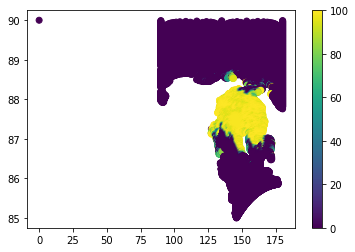

CPU times: user 12.3 s, sys: 79.9 ms, total: 12.4 s
Wall time: 13.1 s


In [30]:
%%time

obs_full = np.zeros([len(obs_latlon), 3])
for i in range(len(obs_space)):
    lat_point = obs_latlon[i][0]
    lon_point = obs_latlon[i][1]
    obs_point = float(obs_data0.isel(x=int(obs_space[i][2])).isel(y=int(obs_space[i][3])))
    obs_full[i] = [lat_point, lon_point, obs_point]

cmap1 = plt.cm.viridis
plt.scatter(obs_full[:, 1], obs_full[:, 0], c=obs_full[:, 2], cmap=cmap1)
plt.colorbar()
plt.show()

In [31]:
%%time

data_compare = np.zeros([len(clim_latlon), 5])
for i in range(len(clim_space)):
    lat_point = clim_latlon[i][0]
    lon_point = clim_latlon[i][1]
    clim_point = float(clim_data0.isel(ni=int(clim_space[i][2])).isel(nj=int(clim_space[i][3])))
    test_point = [obs_latlon[i][0], obs_latlon[i][1]]
    dist, index = spatial.KDTree(clim_latlon).query(test_point)
    obs_coords = obs_space[index]
    obs_point = float(obs_data0.isel(y=int(obs_coords[3])).isel(x=int(obs_coords[2])))
    dif_point = clim_point - obs_point
    compare_point = [lat_point, lon_point, obs_point, clim_point, dif_point]
    data_compare[i] = compare_point

CPU times: user 1min 45s, sys: 356 ms, total: 1min 45s
Wall time: 1min 45s


In [32]:
# get rid of rows with nan
not_nan = np.where((data_compare[:, 4] >= 0))
data_compare = data_compare[not_nan]

In [33]:
lat = data_compare[:, 0]
lon = data_compare[:, 1]
obs = data_compare[:, 2]
clim = data_compare[:, 3]
dif = data_compare[:, 4]

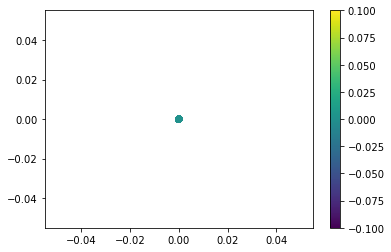

In [34]:
# plot map of differences
cmap1 = plt.cm.viridis
plt.scatter(lon, lat, c=obs, cmap=cmap1)
plt.colorbar()
plt.show()

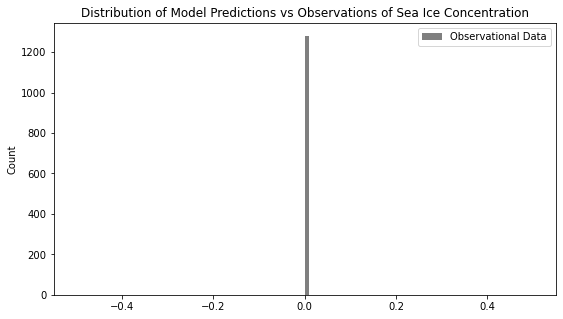

In [16]:
# plot histogram of each
plt.figure(figsize=(9, 5))
#plt.hist(data_compare[:, 3], bins=100, color='r', alpha=0.5, label='Model Data')
plt.hist(data_compare[:, 2], bins=100, color='k', alpha=0.5, label='Observational Data')
plt.legend()
plt.ylabel('Count')
plt.title('Distribution of Model Predictions vs Observations of Sea Ice Concentration')
#plt.xlim([1, 100])   #----- add x-axis limits if desired
#plt.ylim([0, 5000])
plt.show()

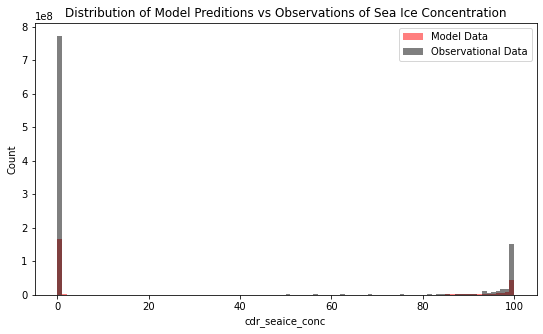

In [17]:
plt.figure(figsize=(9, 5))
clim_data_tc.plot.hist(bins=100, color='r', alpha=0.5, label='Model Data')
obs_data_tc.plot.hist(bins=100, color='k', alpha=0.5, label='Observational Data')
plt.legend()
plt.ylabel('Count')
plt.title('Distribution of Model Preditions vs Observations of Sea Ice Concentration')
plt.show()